### IMPORTS

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier

## DATA LOADING

In [118]:
# Set pandas options to display all columns
pd.set_option('display.max_columns', None)

# Set pandas options to display all rows
pd.set_option('display.max_rows', None)

teams = pd.read_csv("../datasets/teams.csv")

As it was stated before, we decided to use the `teams.csv` dataset to start building the model. In order to accomplish that, we needed to check what features were available and what were the ones that should be removed due to lack of relevance or direct correlation with the target variable.

The features available in the `teams.csv` dataset are:

- `year` - The year the data was collected (important as the data for a certain year will be used to predict the next year's results);
- `lgID` - The league the team is part of (doesn't impact the model as all teams are from the same league);
- `tmID` - The team ID (important to identify the team and can be used to merge with other datasets);
- `franchID` - The franchise ID (basically the same as the team ID);
- `confID` - The conference ID (considering that four teams from each conference make the playoffs, this feature can be important);
- `divID` - The division ID (this feature will be removed as all rows are NaN);
- `rank` - The team's rank in the division;
- `playoff` - Whether the team made the playoffs or not;
- `seeded` - Whether the team was seeded or not;
- `firstRound`, `semis`, `final` - Whether the team made it to the first round, semis or finals of the playoffs;
- `name` - The team's name;
- `Team Stats` (will be important as the stats directly impact the team performance thus the playoff qualification):
    - `o_fgm` - Opponent field goals made;
    - `o_fga` - Opponent field goals attempted;
    - `o_ftm` - Opponent free throws made;
    - `o_fta` - Opponent free throws attempted;
    - `o_3pm` - Opponent three-pointers made;
    - `o_3pa` - Opponent three-pointers attempted;
    - `o_oreb` - Opponent offensive rebounds;
    - `o_dreb` - Opponent defensive rebounds;
    - `o_reb` - Opponent total rebounds;
    - `o_asts` - Opponent assists;
    - `o_pf` - Opponent personal fouls;
    - `o_stl` - Opponent steals;
    - `o_to` - Opponent turnovers;
    - `o_blk` - Opponent blocks;
    - `o_pts` - Opponent points;
    - `d_fgm` - Defensive field goals made;
    - `d_fga` - Defensive field goals attempted;
    - `d_ftm` - Defensive free throws made;
    - `d_fta` - Defensive free throws attempted;
    - `d_3pm` - Defensive three-pointers made;
    - `d_3pa` - Defensive three-pointers attempted;
    - `d_oreb` - Defensive offensive rebounds;
    - `d_dreb` - Defensive defensive rebounds;
    - `d_reb` - Defensive total rebounds;
    - `d_asts` - Defensive assists;
    - `d_pf` - Defensive personal fouls;
    - `d_stl` - Defensive steals;
    - `d_to` - Defensive turnovers;
    - `d_blk` - Defensive blocks;
    - `d_pts` - Defensive points;
    - `tmORB` - Team offensive rebounds (maintains value 0 for all rows, will be removed);
    - `tmDRB` - Team defensive rebounds (maintains value 0 for all rows, will be removed);
    - `tmTRB` - Team total rebounds (maintains value 0 for all rows, will be removed);
    - `opptmORB` - Opponent team offensive rebounds (maintains value 0 for all rows, will be removed);
    - `opptmDRB` - Opponent team defensive rebounds (maintains value 0 for all rows, will be removed);
    - `opptmTRB` - Opponent team total rebounds (maintains value 0 for all rows, will be removed);
    - `won` - Number of games won;
    - `lost` - Number of games lost;
    - `GP` - Games played;
    - `homeW` - Home wins;
    - `homeL` - Home losses;
    - `awayW` - Away wins;
    - `awayL` - Away losses;
    - `confW` - Conference wins;
    - `confL` - Conference losses;
    - `min` - Minutes played;
- `attend` - Attendance (probably not relevant for the model);
- `arena` - Arena name (categorical feature that will probably not be impactful for the model);

### INITIAL DATA CLEANING

In [119]:
# Converting Year to int
teams['year'] = teams['year'].astype(int)

# Mapping playoff column to 0 and 1
teams['playoff'] = teams['playoff'].map({'Y': 1, 'N': 0})

# Now we need to shift the playoff column from a year to the next so the playoff is predicted by the year before
teams['playoff'] = teams.groupby('franchID')['playoff'].shift(-1)
teams.loc[teams['franchID'] != teams['franchID'].shift(-1), 'playoff'] = np.nan


# Checking if there are collumns with all rows the same and dropping them
cols_with_same_values = []
for col in teams.columns:
    if len(teams[col].unique()) == 1:
        cols_with_same_values.append(col)

teams = teams.drop(cols_with_same_values, axis=1)

# Check the number of nulls in each column
null_counts = teams.isnull().sum()
print("\nNull Counts:\n", null_counts)



Null Counts:
 year            0
tmID            0
franchID        0
confID          0
rank            0
playoff        20
firstRound     62
semis         104
finals        122
name            0
o_fgm           0
o_fga           0
o_ftm           0
o_fta           0
o_3pm           0
o_3pa           0
o_oreb          0
o_dreb          0
o_reb           0
o_asts          0
o_pf            0
o_stl           0
o_to            0
o_blk           0
o_pts           0
d_fgm           0
d_fga           0
d_ftm           0
d_fta           0
d_3pm           0
d_3pa           0
d_oreb          0
d_dreb          0
d_reb           0
d_asts          0
d_pf            0
d_stl           0
d_to            0
d_blk           0
d_pts           0
won             0
lost            0
GP              0
homeW           0
homeL           0
awayW           0
awayL           0
confW           0
confL           0
min             0
attend          0
arena           0
dtype: int64


As the columns `firstRound`, `semis` and `finals` are the ones that have null values and can take the values of 'W', 'L, or NaN we need to find a way to fix this. Since the most important part for our prediction is the regular season performance we could just remove those columns. However, we decided to keep them and fill the NaN values with -1, the 'W' values with 1 and the 'L' values with 0. This way we can use these columns as features for the model.

In [120]:
# Define a custom function to replace values
def replace_values(value):
    if pd.isna(value):
        return -1
    elif value == 'W':
        return 1
    elif value == 'L':
        return 0
    return value

# Apply the custom function to the columns
teams['firstRound'] = teams['firstRound'].apply(replace_values)
teams['semis'] = teams['semis'].apply(replace_values)
teams['finals'] = teams['finals'].apply(replace_values)

teams.sort_values(by=['franchID','year'], inplace=True)

Now we need to find a way to treat categorical features such as `name` and `arena`. For that, we will check the number of unique values for each of the categorical features and decide what strategy to use.

In [121]:
# Select categorical columns
categorical_columns = teams.select_dtypes(include=['object']).columns

# Get the number of unique values for each categorical column
unique_values = teams[categorical_columns].nunique()

print(unique_values)

tmID        20
franchID    18
confID       2
name        20
arena       22
dtype: int64


Considering the number of unique values is too high and the columns generated on one-hot encoding would be too many, we decided to use `Sckit-learn`'s `LabelEncoder` to transform the categorical features into numerical ones as there is no ordinal relationship between the values.

In [122]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in categorical_columns:
    teams[col] = le.fit_transform(teams[col])

categorical_df = teams[categorical_columns]
print(categorical_df)

     tmID  franchID  confID  name  arena
0       0         0       0     0     11
1       0         0       0     0     11
2       1         1       0     1      4
3       1         1       0     1      4
4       1         1       0     1      4
5       1         1       0     1      4
6       1         1       0     1      4
7       1         1       0     1      4
8       1         1       0     1     17
9       2         2       0     2     19
10      2         2       0     2     19
11      2         2       0     2     19
12      2         2       0     2     19
13      3         3       0     3     12
14      3         3       0     3     12
15      3         3       0     3     12
16      3         3       0     3     12
86     12         4       0    12      3
87     12         4       0    12      3
88     12         4       0    12      3
17      4         4       0     4     10
18      4         4       0     4     10
19      4         4       0     4     10
20      4       

Now for statistical features, we decided to create new features that represent the team's performance in the regular season. We will create the following features:

- win_rate: the ratio of games won to games played;
- points_diff: the difference between the points scored and the points conceded;
- poss: the number of possessions;
- off_rating: the number of points scored per 100 possessions;
- def_rating: the number of points conceded per 100 possessions;
- margin: the difference between the offensive and defensive ratings;
- net_rating: an estimate of the team's point differential per 100 possessions;
- pace: the number of possessions per 40 minutes;
- ts_pct: the true shooting percentage - A measure of shooting efficiency that takes into account 2-point field goals, 3-point field goals, and free throws;


In [123]:
teams['win_rate'] = teams['won'] / (teams['won'] + teams['lost'])
teams['point_diff'] = teams['o_pts'] - teams['d_pts']
teams['Tm_Poss'] = (teams['o_fga'] + 0.4 * teams['o_fta'] - 
                    1.07 * (teams['o_oreb'] / (teams['o_oreb'] + teams['d_dreb'])) * 
                    (teams['o_fga'] - teams['o_fgm']) + teams['o_to'])

teams['Opp_Poss'] = (teams['d_fga'] + 0.4 * teams['d_fta'] - 
                     1.07 * (teams['d_oreb'] / (teams['d_oreb'] + teams['o_dreb'])) * 
                     (teams['d_fga'] - teams['d_fgm']) + teams['d_to'])

teams['poss'] = 0.5 * (teams['Tm_Poss'] + teams['Opp_Poss'])

teams['off_rating'] = (teams['o_pts'] / teams['poss']) * 100

# Calculate defensive rating
teams['def_rating'] = (teams['d_pts'] / teams['poss']) * 100

# Calculate margin
teams['margin'] = teams['off_rating'] - teams['def_rating']

# Calculate net rating
teams['net_rating'] = (teams['point_diff'] / teams['poss']) * 100

# Calculate the pace
teams['pace'] = 40 * ((teams['Tm_Poss'] + teams['Opp_Poss']) / (2 * (teams['min'] / 5)))


# Calculate True Shooting Attempts (TSA)
teams['TSA'] = teams['o_fga'] + 0.44 * teams['o_fta']

# Calculate True Shooting Percentage (TS%)
teams['TS'] = teams['o_pts'] / (2 * teams['TSA'])

# Drop intermediate columns
teams = teams.drop(columns=['Tm_Poss', 'Opp_Poss', 'TSA'])



   year  tmID  franchID  confID  rank  playoff  firstRound  semis  finals  \
0     9     0         0       0     7      1.0          -1     -1      -1   
1    10     0         0       0     2      NaN           0     -1      -1   
2     1     1         1       0     8      1.0          -1     -1      -1   
3     2     1         1       0     4      1.0           1      1       0   
4     3     1         1       0     2      1.0           0     -1      -1   

   name  o_fgm  o_fga  o_ftm  o_fta  o_3pm  o_3pa  o_oreb  o_dreb  o_reb  \
0     0    895   2258    542    725    202    598     340     737   1077   
1     0   1089   2428    569    755    114    374     404     855   1259   
2     1    812   1903    431    577    131    386     305     630    935   
3     1    746   1780    410    528    153    428     309     639    948   
4     1    770   1790    490    663    211    527     302     653    955   

   o_asts  o_pf  o_stl  o_to  o_blk  o_pts  d_fgm  d_fga  d_ftm  d_fta  d_3pm  \

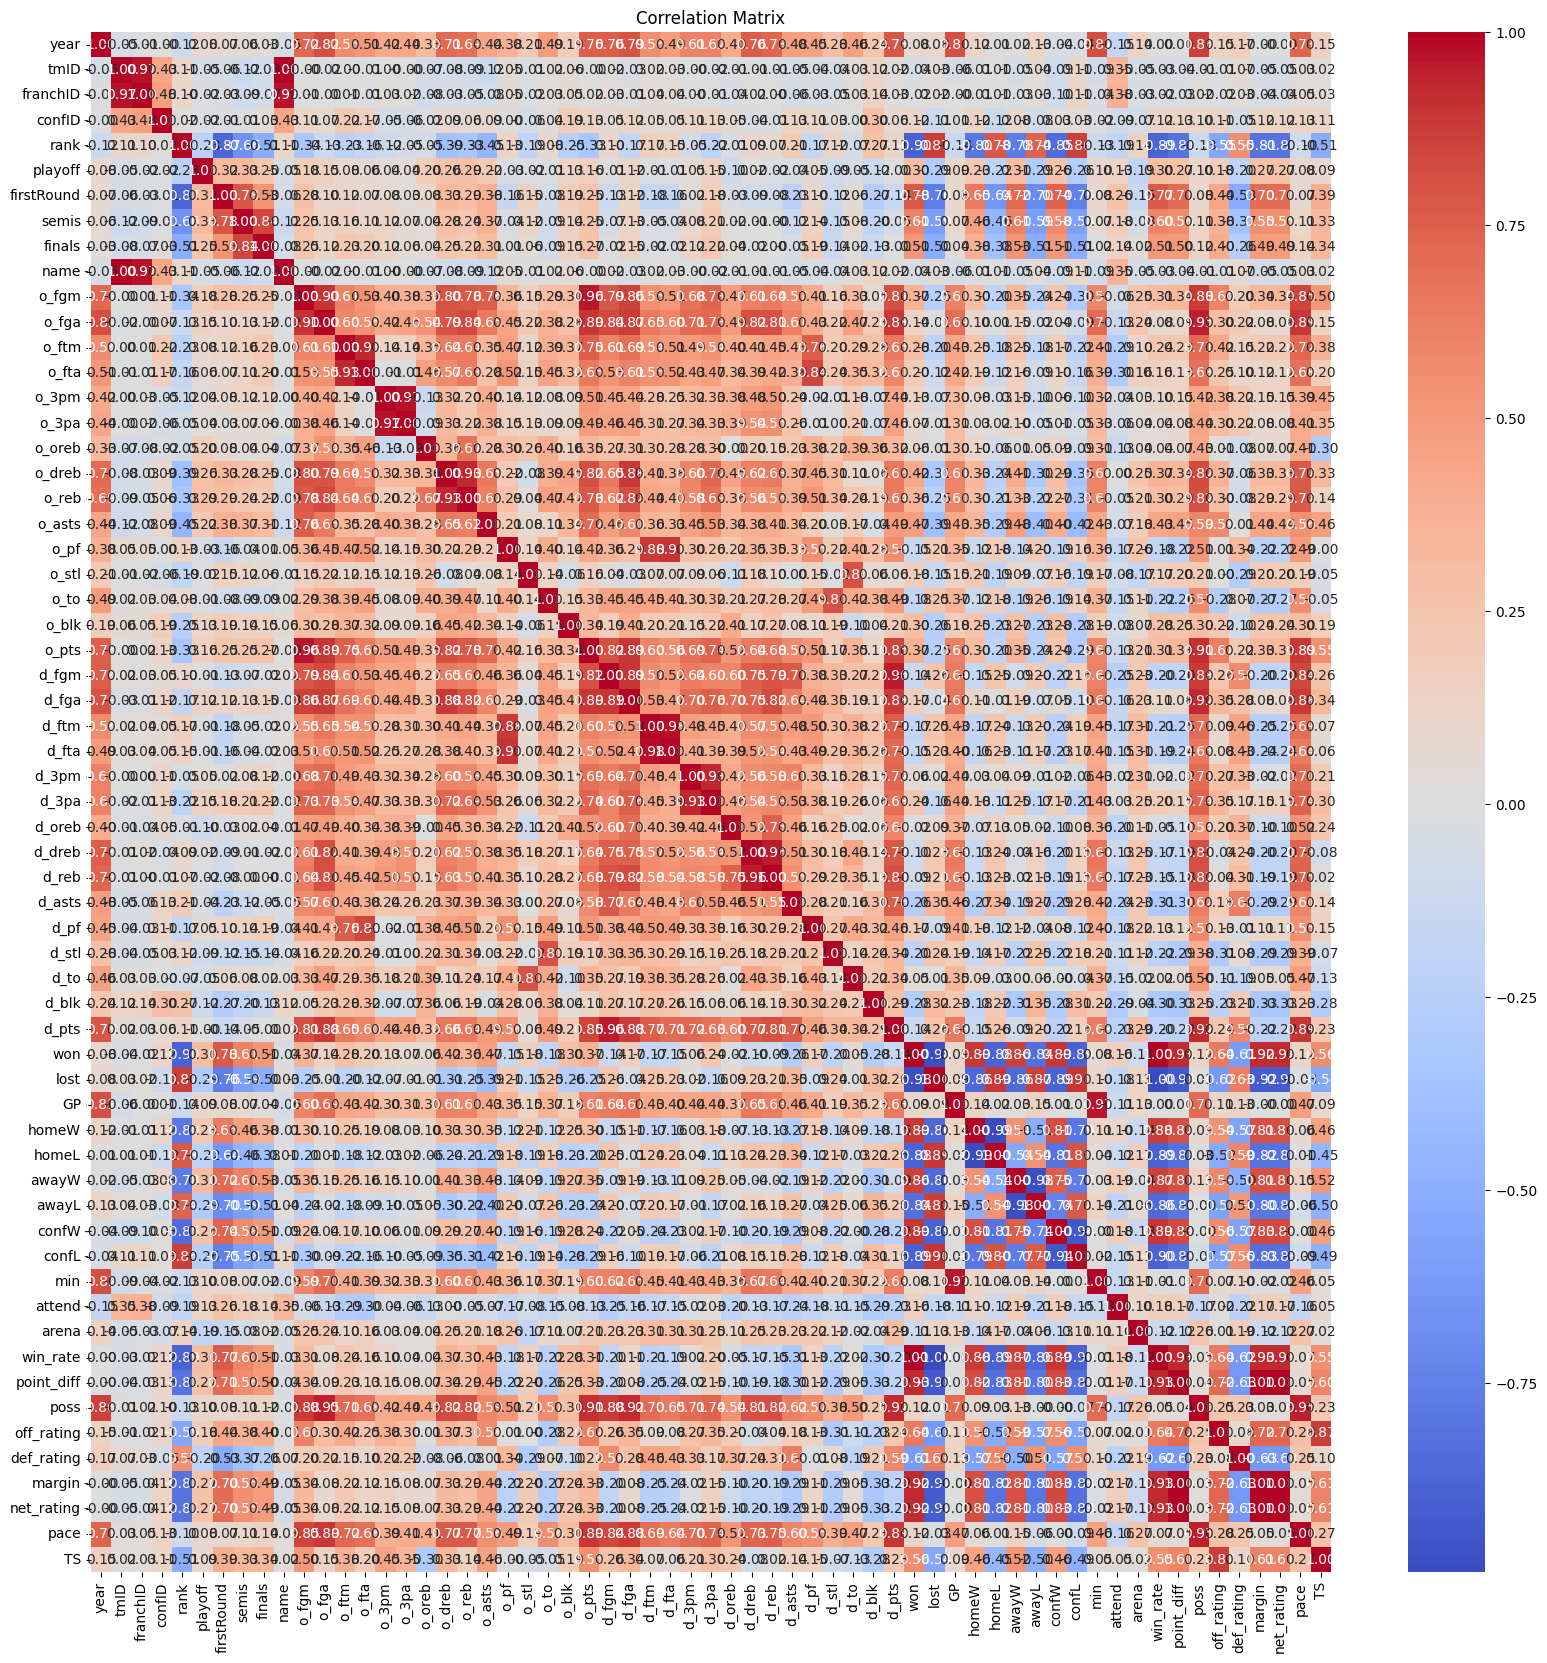

Top correlated features with 'playoff':
 playoff       1.000000
semis         0.333398
firstRound    0.317116
awayW         0.308676
won           0.304224
win_rate      0.295957
awayL         0.291828
lost          0.288384
o_reb         0.286745
point_diff    0.272085
margin        0.270233
net_rating    0.270233
o_dreb        0.264963
confL         0.264687
confW         0.259823
finals        0.247811
rank          0.234472
homeW         0.232573
homeL         0.220331
o_asts        0.215452
def_rating    0.201752
o_oreb        0.197236
arena         0.190778
o_fgm         0.184923
off_rating    0.180505
o_pts         0.162240
o_fga         0.153276
d_3pa         0.147018
o_blk         0.133895
attend        0.125527
d_fga         0.116397
d_blk         0.115328
poss          0.103089
d_oreb        0.102321
min           0.099596
d_stl         0.091635
GP            0.090207
TS            0.086659
pace          0.083385
year          0.082303
o_ftm         0.076274
o_fta         0.

In [125]:

# Compute correlation matrix
corr_matrix = teams.corr()

# Visualize the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Identify top features correlated with 'playoff'
corr_with_target = corr_matrix['playoff'].abs().sort_values(ascending=False)
print("Top correlated features with 'playoff':\n", corr_with_target)

# Identify features to drop
threshold = 0.8  # Set a threshold for high correlation
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > threshold]

# Print highly correlated pairs
print("Highly correlated pairs (above threshold):\n", high_corr_pairs)

# Drop one feature from each pair of highly correlated features
features_to_drop = set()
for i, j in high_corr_pairs:
    if corr_with_target[i] > corr_with_target[j]:
        features_to_drop.add(j)
    else:
        features_to_drop.add(i)

print("Features to drop:\n", features_to_drop)

# Drop the identified features
teams_reduced = teams.drop(columns=features_to_drop)

# Display the remaining features
print("Remaining features:\n", teams_reduced.columns)